In [2]:
import numpy as np
import params
from scipy.optimize import root
from matplotlib import pyplot as plt
import time

beta = .442
beta1 = .55
delta = 0.6415
sigma = 3
A = 1
alpha = .35
nvec = np.array([1,1,.2])
L = np.sum(nvec)
SStol = 1.E-10
xi = .4
T = 40


params1 = (.55, sigma, nvec, L, A, alpha, delta, SStol)
params2 = (beta, sigma, nvec, L, A, alpha, delta, SStol, 1000, xi, 45)

### Exercise 2.1

In [12]:
f_params = (nvec, A, alpha, delta)
def feasible(f_params, bvec_guess):
    '''
    Purpose: 
        Determine the feasibility of a given steady state guess based on a set of wealth allocations
    Inputs 
        f params = (nvec, A, alpha, delta)
        bvec guess = np.array([scalar, scalar])
    Outputs 
        b_cnstr (boolean list, len=2) [which element of bvec guess is 
            likely responsible for any of the consumption nonnegativity 
            constraint violations identified in c cnstr]
            - If the first element of c cnstr is True, then the first element of b cnstr is True. 
            - If the second element of c cnstr is True, then both elements of b cnstr are True. 
            - if the last element of c cnstr is True, then the last element of b cnstr is True.
        c_cnstr (boolean list, len=3) [True if cs ≤ 0]
        K_cnstr (boolean list, len=1) [True if K ≤ 0]
    '''
    nvec, A, alpha, delta = f_params
    # First we want to check whether the savings are collectively nonnegative
    K = np.sum(bvec_guess)
    K_cnstr = np.array([K <= 0])
   
    # Calculate wage and rental rate parameter 
    r = alpha * A * ( (np.sum(nvec) / abs(K)) ** (1-alpha) ) - delta
    w = (1-alpha) * A * ( ( abs(K) / np.sum(nvec)) ** (alpha) )
    if (K <= 0):
        r = r * -1
        w = w * -1
    
    
    # Each Generations Consumption
    c = np.array([0.0,0.0,0.0])
    c[0] = w*nvec[0] - bvec_guess[0]
    c[1] = w*nvec[1] - bvec_guess[1] + bvec_guess[0]*(1+r)
    c[2] = w*nvec[2] + bvec_guess[1]*(1+r)
    c_cnstr = np.array(c <= 0)
    
    
    # Why are certain generations getting negative consumption
    b_cnstr = np.array((False, False))
    if (c_cnstr[0]): 
        b_cnstr[0] = True
    if (c_cnstr[1]): 
        b_cnstr[0] = True
        b_cnstr[1] = True
    if (c_cnstr[2]):
        b_cnstr[1] = True   
    return [b_cnstr, c_cnstr, K_cnstr]

In [13]:
guess1 = np.array([1.0, 1.2])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, guess1)
print("K_cnstr", K_cnstr)
print("c_cnstr", c_cnstr)
print("b_cnstr:", b_cnstr)

K_cnstr [False]
c_cnstr [ True False False]
b_cnstr: [ True False]


In [14]:
guess2 = np.array([0.06, -.001])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, guess2)
print("K_cnstr", K_cnstr)
print("c_cnstr", c_cnstr)
print("b_cnstr:", b_cnstr)

K_cnstr [False]
c_cnstr [False False False]
b_cnstr: [False False]


In [16]:
guess2 = np.array([0.1, 0.1])
b_cnstr, c_cnstr, K_cnstr = feasible(f_params, guess2)
print("K_cnstr", K_cnstr)
print("c_cnstr", c_cnstr)
print("b_cnstr:", b_cnstr)

K_cnstr [False]
c_cnstr [False False False]
b_cnstr: [False False]


### Exercise 2.2

In [8]:
params = (beta, sigma, nvec, L, A, alpha, delta, SStol)
def funcfact(params):
    def utility(c):
        '''
        utility function
        Inputs:
            consumption
        Outputs
        '''
        if (c <= 0):
            return -9999999
        else:
            u = ((c ** (1-sigma)) - 1)/(1-sigma)
            return u
    def du(c):
        '''
        utility function
        Inputs:
            consumption
        Outputs
        '''
        if (c <= 0): return -99999999
        else:
            return (c ** (-sigma))
    
    return utility, du


        
u, du = funcfact(params)

b_ss       : [0.019312529832027088, 0.05841109592113676]
c_ss       : [0.18241212755849867, 0.20961468030898922, 0.24087386507209851]
w_ss       : 0.20172465739052575
r_ss       : 2.433062339127069
K_ss       : 0.07772362575316386
Y_ss       : 0.6827603788602411
C_ss       : 0.6329006729395864
EulErr_ss  : [-1.3926637620897964e-12, 2.6290081223123707e-12]
RCerr_ss   : 8.326672684688674e-17
ss_time    : 0.04398538899840787


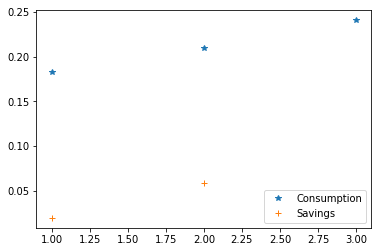

In [9]:
def modeldef(v, beta, sigma, nvec, L, A, alpha, delta):
    '''
        Defines the model
        Inputs:
            v - vector of solutions 
            beta - discount rate
            sigma - rate of relative risk aversion
            nvec - how much each population works 
            L - aggregate labor 
            A - technology
            alpha - capital share
            delta - depreciation
        Return:
            list of functions
    '''
    b2, b3 = v
    k = b2 + b3
    r = ( ( alpha * A * ( (np.sum(nvec) / k))**(1-alpha) )) - delta
    w = (  (1-alpha) * A * ( ( k / np.sum(nvec))**(alpha) ) )
    c1 = w*nvec[0] - b2
    c2 = w*nvec[1] + (1+r)*b2 - b3
    c3 = w*nvec[2] + (1+r)*b3
    rv = []
    rv.append( du(c1) - ( (beta*(1+r))*du(c2) ) )
    rv.append( du(c2) - ( (beta*(1+r))*du(c3) ) )
    return rv
    
    

def get_SS(params, bvec_guess, SS_graphs):
    '''
    Purpose: 
        Get the steady state of the function from a guess
    Inputs:
        params = beta, sigma, nvec, L, A, alpha, delta, SS_tol
        bvec_guess = np.array([scalar, scalar])
        SS_graphs (boolean to display graphs if true)
    Outputs 
        ss_output: dictionary containing the model parameters in steady state. 
    '''
    start_time = time.perf_counter() 
    ret = root(modeldef, bvec_guess, method = 'hybr', args=(params[:7]) )
    b2, b3 = ret.x
    e1, e2 = ret.fun
    beta, sigma, nvec, L, A, alpha, delta, SStol = params

    k = b2 + b3
    r = ( (np.sign(k) * alpha * A * ( (np.sum(nvec) / abs(k))**(1-alpha) )) - delta) 
    w = ( np.sign(k) * (1-alpha) * A * ( ( abs(k) / np.sum(nvec))**(alpha) ) )
    c1 = w*nvec[0] - b2
    c2 = w*nvec[1] + (1+r)*b2 - b3
    c3 = w*nvec[2] + (1+r)*b3
    C = c1 + c2 + c3
    Y = A * (L**(1-alpha)) * (k**alpha)
    
     
    rv = {}
    rv['b_ss'] = [b2, b3]
    rv['c_ss'] = [c1, c2, c3]
    rv['w_ss'] = w
    rv['r_ss'] = r
    rv['K_ss'] = k
    rv['Y_ss'] = Y
    rv['C_ss'] = C
    rv['EulErr_ss'] = [e1, e2]
    rv['RCerr_ss'] = Y - C - delta*k

    
    
    if (SS_graphs == True):
        fig = plt.figure()
        age = np.array((1,2,3))
        plt.plot(age, rv['c_ss'], '*', label="Consumption")
        plt.plot(age[:2], rv['b_ss'], '+', label="Savings")
        plt.legend(loc="lower right")
    
    end_time = time.perf_counter()
    rv['ss_time'] = end_time - start_time
    
    return rv
    
d = get_SS(params, [.1, .1], True)    
for key, item in d.items():
    print("{:10s}".format(key), ":", item)

b_ss       : [0.028176918915182085, 0.07686545131079861]
c_ss       : [0.19597527701928497, 0.2286159413839988, 0.26669307195186887]
w_ss       : 0.22415219593446706
r_ss       : 1.8863765057189819
K_ss       : 0.1050423702259807
Y_ss       : 0.7586689708551193
C_ss       : 0.6912842903551526
EulErr_ss  : [6.87805368215777e-12, 2.5295321393059567e-12]
RCerr_ss   : 9.71445146547012e-17
ss_time    : 0.02900983400104451


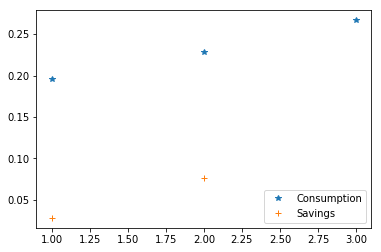

In [10]:
params = (beta1, sigma, nvec, L, A, alpha, delta, SStol)
d = get_SS(params1, [.1, .1], True)    
for key, item in d.items():
    print("{:10s}".format(key), ":", item)

In [11]:
def hhsol3(V, beta, n, w, wp, wpp, r, rp, rpp, b20):
    '''
    Corner Solution
    '''
    b21, b31, b32 = V 
    rv = []
    rv.append( du(w*n[0] - b21) - ( beta*(1+rp)*du(wp*n[1] + (1+rp)*b21 - b32) ) )
    rv.append( du(wp*n[1] + (1+rp)*b21 - b32) - ( beta*(1+rpp)*du(wpp*n[2] + (1+rpp)*b32 ) ) )
    
    rv.append( du(w*n[1] + (1+r)*b20 - b31) - ( beta*(1+rp)*du(wp*n[2] + (1+rp)*b31 ) ) )
    return rv
    
    
def hhsol2(V, beta, n, w, wp, wpp, rp, rpp):
    '''
    Standard Solution
    '''
    b21, b32 = V 
    rv = []
    rv.append( du(w*n[0] - b21) - ( beta*(1+rp)*du(wp*n[1] + (1+rp)*b21 - b32) ) )
    rv.append( du(wp*n[1] + (1+rp)*b21 - b32) - ( beta*(1+rpp)*du(wpp*n[2] + (1+rpp)*b32 ) ) )
    return rv
    
    
def TPI(current , parameters):
    '''
    A function which solves for the optimal transition path through value function iteration. 
    Inputs:
        parameters = beta, sigma, nvec, L, A, 
        alpha, delta, SS_tol, max_iterations, xi
    Outputs: 
        Ideal capital path
    '''
    beta, sigma, nvec, L, A, alpha, delta, SS_tol, max_iters, xi, T = parameters
    # Solve for SS
    SS = get_SS(parameters[:8], (.1, .1), False)
    # Guess T Economy will be in SS 
    currk = sum(current)
    K_i = np.linspace(currk, SS['K_ss'], T+1)
    K_i = np.append(K_i, K_i[-1])

    for i in range(1, max_iters):
        # Guess K_i = {K_i1, K_i2, ... K_iT} which implies 
        # r_i = {r_i1, r_i2, ... r_iT} and w_i = {w_i1, w_i2, ... w_iT}
        r = alpha * A * ((L / K_i)**(1-alpha)) - delta
        r = np.append(r, r[-1])
        w = (1-alpha)*A*(K_i / L) **(alpha)
        w = np.append(w, w[-1])
        b2 = np.zeros_like(K_i)
        b3 = np.zeros_like(K_i)
        Kp = np.copy(K_i)
        EuErrs = np.zeros((2, len(K_i)))
        b2[0] = current[0]
        b3[0] = current[1]
        Kp[0] = currk
        # HH solution to optimal b2, and b3 + Calculate K'
        g = beta, nvec, w[1], w[2], w[3], r[1], r[2], r[3], current[0]
        ret = root(hhsol3, [.1, .1, .1], method = 'hybr', args=(g) )
        b2[1], b3[1], b3[2] = ret.x
        EuErrs[0,1], EuErrs[1,2], EuErrs[1,1] = ret.fun
        Kp[1] = b2[1] + b3[1]
        
        for t in range(2, T+1):
            g = beta, nvec, w[t], w[t+1], w[t+2], r[t+1], r[t+2]
            ret = root(hhsol2, [.1, .1], method = 'hybr', args=(g) )
            b2[t], b3[t+1] = ret.x
            EuErrs[0,t], EuErrs[0,t] = ret.fun
            Kp[t] = b2[t] + b3[t]
        
        totaldiff = np.sum(((K_i - Kp)/K_i)**2)
        if (totaldiff < SS_tol):
            print("Total difference:", totaldiff)
            print("Function Converged after {} iterations".format(i), 
                  "with epsilon {} in total squared deviations".format(SStol))
            print("Yeet XD")
            break
        else:
            K_i = xi*Kp + (1-xi)*K_i
    
    r = alpha * A * ((L / Kp)**(1-alpha)) - delta
    w = (1-alpha)*A*(Kp / L) **(alpha)
    for i in range(4):
        r = np.append(r, r[-1])
        w = np.append(w, w[-1])
        Kp = np.append(Kp, Kp[-1])
    
    return (Kp, EuErrs, r, w)
    
params = (beta, sigma, nvec, L, A, alpha, delta, SStol, 1000, xi, T)    

kp, errs, r, w = TPI([.5, .5] , params)  


Total difference: 8.137488997864269e-11
Function Converged after 56 iterations with epsilon 1e-10 in total squared deviations
Yeet XD


[1.         0.3567039  0.12026671 0.08834094 0.08072252 0.0786007
 0.0779828  0.07780048 0.07774649 0.07773048 0.07772574 0.07772434
 0.07772392 0.0777238  0.07772376 0.07772375 0.07772375 0.07772374
 0.07772374 0.07772374 0.07772374 0.07772373 0.07772373 0.07772373
 0.07772373 0.07772372 0.07772372 0.07772372 0.07772371 0.07772371
 0.07772371 0.0777237  0.0777237  0.0777237  0.07772369 0.07772369
 0.07772368 0.07772368 0.07772367 0.07772367 0.07772366 0.07772363
 0.07772363 0.07772363 0.07772363 0.07772363]


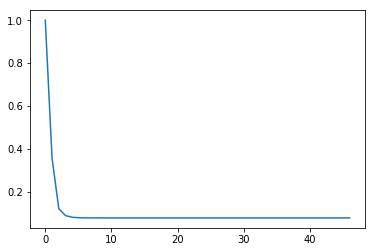

In [12]:
fig = plt.figure
x = np.linspace(0, T+6, T+6)
plt.plot(x, kp)
print(kp)

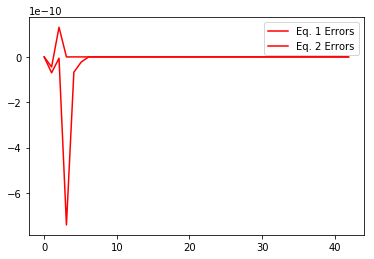

In [13]:
fig = plt.figure()
plt.plot(x[:T+2], errs[0], 'r-', label="Eq. 1 Errors")
plt.plot(x[:T+2], errs[1], 'r-', label="Eq. 2 Errors")
plt.legend()

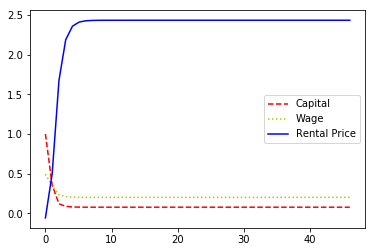

In [14]:
fig = plt.figure()
plt.plot(x, kp, 'r--', label="Capital")
plt.plot(x, w, 'y:', label="Wage")
plt.plot(x, r, 'b-', label="Rental Price")
plt.legend()


After 12 periods the capital value was never farther than .00001 away from the steady state value. This is becuase without shocks the system was effectively in steady state and since the it was effectrively already in the steady state, the adjustments made by agents asymptotically slowed as they tried to get closer and closer to the perfect steady state. However, it was always above the steady state until machine precision  made it appear equivalent and throughout that whole time it was monotonically decreasing